In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import concatenate

%load_ext pycodestyle_magic
LEARNING_RATE = 1e-4
IMAGE_PX = 128

LOSS_WEIGHT = 15

In [2]:
%flake8_on --max_line_length 115

def weighted_bce_dice_loss(y_true, y_pred):
    return tf.reduce_sum(tf.nn.weighted_cross_entropy_with_logits(y_true, y_pred, LOSS_WEIGHT))


# model.save('./model.save')
model = tf.keras.models.load_model('./trained_models/0.8_15_1000/', compile=False)

In [3]:
model.compile(optimizer=Adam(lr=LEARNING_RATE),
              loss=weighted_bce_dice_loss,
              metrics=['accuracy'])

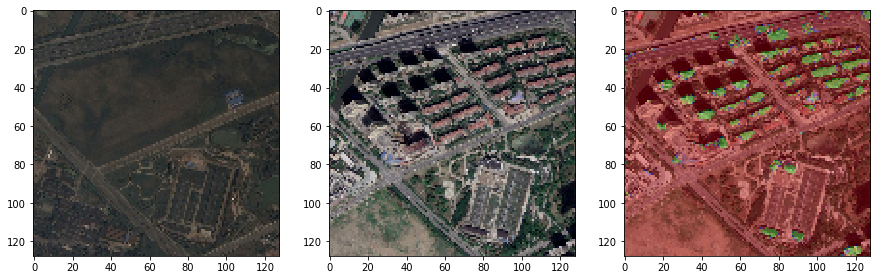

In [6]:
base_path = './test_set/1/'
a_path = base_path + 'Before.png'
b_path = base_path + 'After.png'


def prepare_image(path, channels):
    res = tf.image.decode_png(tf.io.read_file(path), channels=channels)
    res = tf.image.convert_image_dtype(res, tf.float32)
    return tf.image.resize(res, [IMAGE_PX, IMAGE_PX])


a = prepare_image(a_path, 3)
b = prepare_image(b_path, 3)

x = concatenate([a, b], axis=2)

x = x[tf.newaxis, ...]

pred = tf.squeeze(model.predict(x)[0])

plt.figure(figsize=(15, 45))

plt.subplot(131)
plt.imshow(a)


plt.subplot(132)
plt.imshow(b)

plt.subplot(133)
plt.imshow(b, alpha=1)
plt.imshow(pred, alpha=0.3, cmap='prism')

result = (b + tf.image.grayscale_to_rgb(tf.reshape(pred, [128, 128, 1])) * [0.25, 0, 0]).numpy()
result[result > 1] = 1
plt.imsave(base_path + 'output.png', result)